# Perfect Reconstruction Filter Bank (PRFB)
Using MST filters.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd

In [2]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [15]:
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


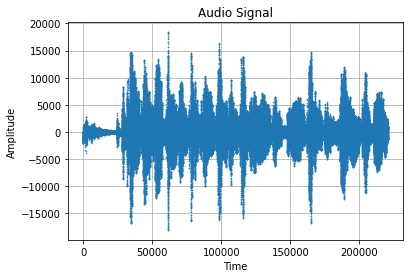

In [16]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Time", "Amplitude", "Audio Signal")

### Low-frequency subband (analysis)
We convolve $x$ with $K_0=[1, 1]$.

In [17]:
L = np.convolve(x[:, 0], [1, 1]).astype(np.int32)

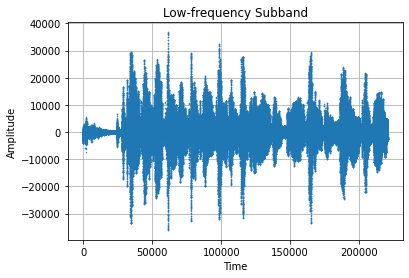

In [18]:
sd.play((L//2).astype(np.int16))
plot(np.linspace(0, len(L)-1, len(L)), L, "Time", "Amplitude", "Low-frequency Subband")

Notice that the gain of this filter is 2.

### High-frequency subband (analysis)
We convolve $x$ with $K_1=[1, -1]$.

In [19]:
H = np.convolve(x[:, 0], [1, -1]).astype(np.int32)

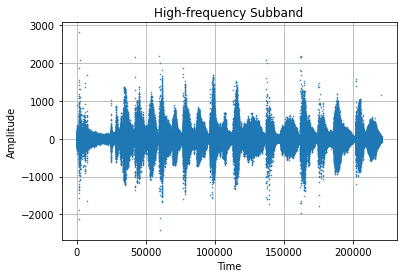

In [20]:
sd.play((H//2).astype(np.int16))
plot(np.linspace(0, len(H)-1, len(H)), H, "Time", "Amplitude", "High-frequency Subband")

Now it's more difficult to see that the signal gain of $K_1$ is 2, but this is the real gain.

### Subsampling (decimation)
Set to zero half of the transform coefficients.

In [21]:
L[::2] = 0
H[::2] = 0

### Low-frequency subband (synthesis)

In [22]:
L = np.convolve(L, [1, 1]).astype(np.int32)

### High frequency subband (synthesis)

In [23]:
H = np.convolve(H, [1, -1]).astype(np.int32)

### Add the subbans

In [24]:
_x = L+H

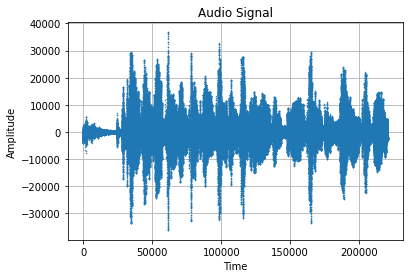

In [25]:
sd.play((_x//2).astype(np.int16))
plot(np.linspace(0, len(_x)-1, len(_x)), _x, "Time", "Amplitude", "Audio Signal")

### Perfect reconstruction test

In [26]:
x.all() == _x.all()

True